# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this notebook we build a (simple, __hello-world-like__) prototype that finds the (approximate) optimal solution for a specific binary optimization problem, using the QAOA algorithm, as introduced [here](https://arxiv.org/abs/1411.4028). We use our ```braket``` SDK for implementing the quantum evolution and ```scipy``` for classical numerical optimization. Goals of this __hello-world__ demo for hybrid workloads: 
- Show that variational hybrid algorithms can be implemented efficiently with our SDK. 
- Show managed job execution for hybrid workload: Specifically, discuss how our Braket service spins up classical compute, brokers the execution, then tears down the environment at the end of the computation. Discuss interaction with other AWS services such as S3 and CloudWatch.  
- Walk through the user workflow and experience. 

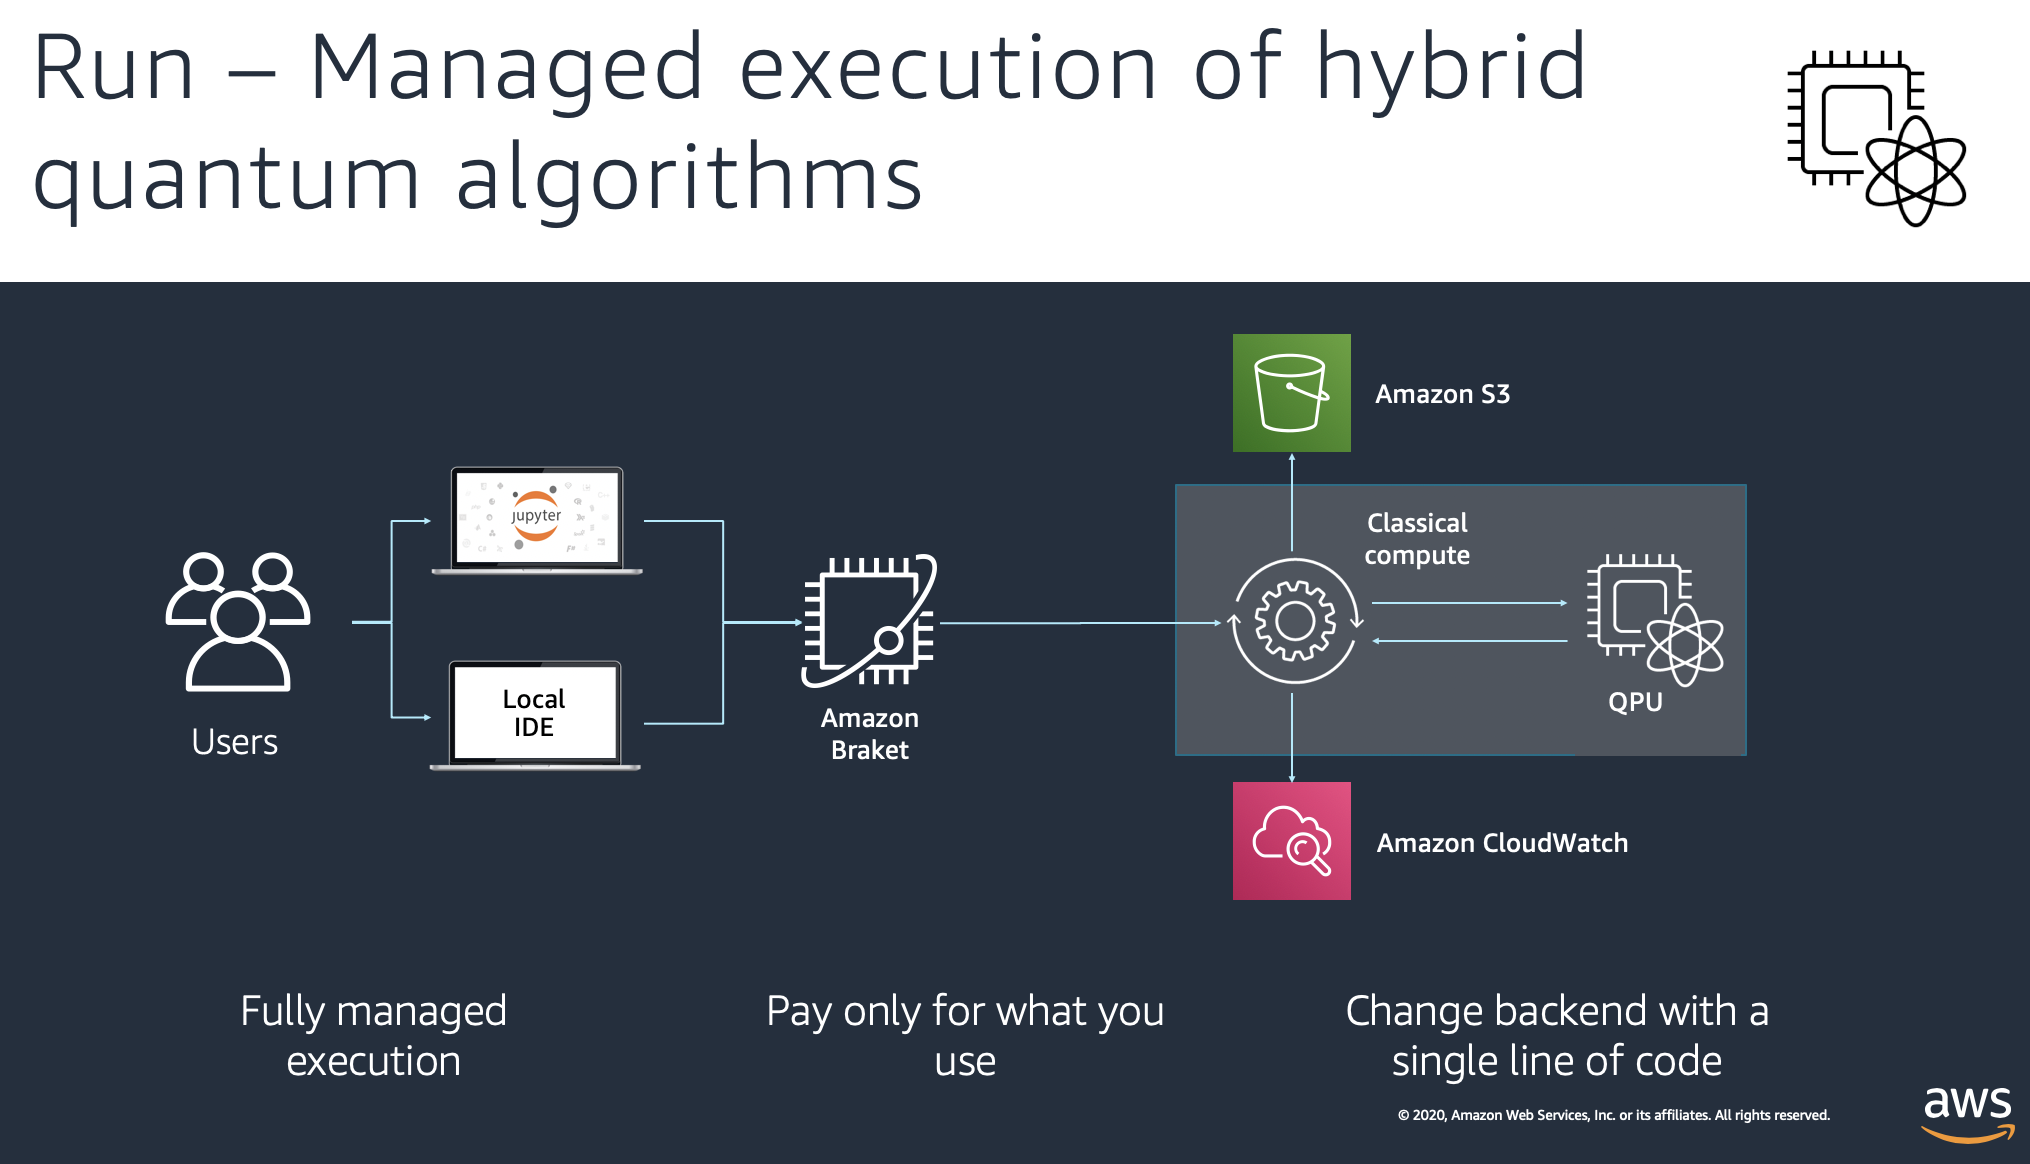

In [1]:
from IPython.display import Image
Image(filename='figures/Braket_Run_scheme.png', width=800, height=800)

__RUN MANAGED HYBRID WORKLOAD__:
- Build quantum algorithms in Jupyter Lab or a local IDE.
- Submit the program together with hardware and backend specifications to the Braket API.
- Select EC2 instance type and configurations for classical part of computation.
- Choose from multiple state-of-the-art simulator or QC backends (for circuit execution).
- Braket will spin up the classical compute and broker the execution between CPU and QPU.
- Pay only for what you use; tear down resources when done. 
- Touchpoints to other AWS services: 
    - All input and output data can be stored in Amazon Simple Storage Service (S3).
    - Logs and custom metrics reported to Amazon CloudWatch. 

## Update your config file

Before we get started, let's make some changes to the file ```config.py``` located in the same folder as this notebook. This holds basic information related to your AWS account and setup. 

1. **region**: This is the AWS Region in which the classical part of the computation will be run. To reduce latency, we recommend "us-west-1" for Rigetti and "us-east-1" for IonQ. 
2. **role**: This is the execution role that allows Amazon Braket to perform actions on your behalf. It was created as part of the setup process. You can find the ARN (this acronym stands for AWS Resource Name) in your AWS console. Open the console, navigate to IAM in the list of AWS services and click on 'Roles'. In the search field, type "AmazonBraketJobExecutionRole" and click on the role. You will find your Role ARN on the top of the page. 
3. **bucket**: This is the S3 bucket you will use for this example. You can either create a new bucket in the AWS console or use an existing one. Make sure this bucket resides in the **region** set above. 
4. **bucket_key**: This is the 'folder' (this is technically not quite correct but let's not worry about it at this point) in which the results of individual circuit evaluations will be stored. You can add anything you like here. It will be created on the fly.

## IMPORTS and SETUP

For classical benchmarking we will be using the python library ```pyqubo```, as used in our helper script ```utils_classical```. If not already present in your virtual environment, you can install this library simply with ```pip install pyqubo```. 

In [2]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
import seaborn as sns
import pickle
import time
import pandas as pd
import json
from datetime import datetime
import tarfile
import os

In [3]:
from utils_classical import plot_colored_graph, plot_colored_graph_simple, solve_classical_ising
from utils_qaoa import kickoff_train, postprocess
# auto reload external files, so that we can edit the external .py file and immediately see the changes here
%load_ext autoreload
%autoreload 2

In [4]:
# AWS imports
import boto3
from braket.circuits import Circuit 
from braket.aws import AwsQuantumSimulator, AwsSession

In [5]:
# import your config information  
import config

In [6]:
# setup session
# from botocore.session import get_session
# creds = get_session().get_credentials()
# session = boto3.Session(aws_access_key_id=creds.access_key, 
#                         aws_secret_access_key=creds.secret_key,
#                         aws_session_token=creds.token, 
#                         region_name=config.region)
# aws_session = AwsSession(boto_session=session)

In [7]:
# setup session
region = config.region
session = boto3.Session(region_name=region)
aws_session = AwsSession(boto_session=session)

In [8]:
# setup client
braket_client = aws_session.braket_client

In [9]:
# S3 bucket
bucket = config.bucket # enter your bucket; see config file

## PROBLEM SETUP: BACKGROUND

__QAOA__ designed for QUBO (quadratic unconstrained binary optimization) problems, specifically graph coloring problems (that are generically NP-hard, with exponentialliy increasing solution space). 

__Graph coloring problem__: Given a graph of nodes and edges, goal is to color each node red or blue, then score a point for each node that is next to a node of different color. Find a coloring that scores the most points. 

__Applications__ can be found in: 
- Clustering for marketing purposes (segment your customer base into different clusters for targeted marketing). 
- Portfolio optimization in finance (vertex corresponds to asset, color refers to sell or buy).
- Resource allocation: distribute airplanes over terminals avoiding obverlap conflicts.

We encode the problem as a __minimization problem__ of an __Ising Hamiltonian__, where the cost function reads $$H_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z}.$$

## MANAGED JOB

In the following we walk through the essential steps for running a managed job on Amazon Braket. These are: (0) Setup our problem, (1) upload problem to S3, (2) package code into single .py file ready for managed job. Upload script to S3 as well, and (3) submit managed job with simple ```create_quantum_job()``` API call. 

### Managed Job with ```boto3``` API CALL

__Step 0__: Setup problem on graph. 

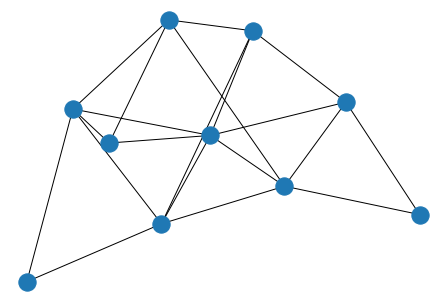

In [10]:
# setup Erdos Renyi graph
n = 10  # 10 nodes
m = 20  # 20 edges

# G = nx.gnm_random_graph(n, m)
G = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(G)

# print edges
# print(list(G.edges));

# draw graph
nx.draw(G, pos)
plt.show()

In [11]:
# set Ising matrix 
Jfull = nx.adjacency_matrix(G).todense()
Jfull = np.array(Jfull)
N = Jfull.shape[0]

# get upper triangular matrix
J = np.zeros((N, N))
for ii in range(0, N):
    for jj in range(ii+1, N):
        J[ii][jj] = Jfull[ii][jj]
# print('Ising matrix:\n', J)

__Step 1__: Upload problem (graph) to S3. 

In [12]:
# store Ising matrix locally w/o header and index as CSV file
data_ising = pd.DataFrame(J)
filename_train = './data_local/data_ising.csv'
data_ising.to_csv(filename_train, header=False, index=False)

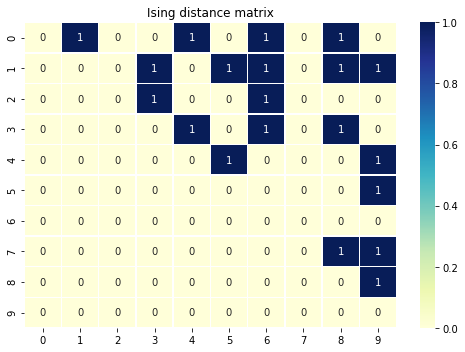

In [13]:
# plot Ising matrix
plt.figure(figsize=[7, 5])
sns.heatmap(data_ising, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();

In [14]:
# helper function to upload to S3
def upload_file(file_name, bucket, object_name=None):
    """
    Upload a file to an S3 bucket
    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = session.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [15]:
# upload Ising matrix to S3
s3_filename = 'data/data_ising.csv' # enter your filename in S3 here 
upload_file(filename_train, bucket, s3_filename)

True

__STEP 2__: Package code into single .py file ready for managed job where user can define underlying hardware in API call. Upload script to S3. 

In [16]:
# local IDE: show training job script for managed job (use ‘! more’ on Windows)
! cat qaoa_braket.py

#!/usr/bin/python3

# A sample program that runs QAOA using the Braket SDK

from __future__ import print_function
import os
import json
import pickle
import sys
import traceback
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import time

# AWS imports
import boto3
from braket.circuits import Circuit
from braket.aws import AwsQuantumSimulator, AwsSession, AwsQpu, AwsQuantumTask, AwsQuantumSimulatorArns, AwsQpuArns
from botocore.session import get_session


########################
# CONTAINER PATH SETUP #
########################

# Braket file directory
prefix = '/opt/ml/'

# Data location
input_path = prefix + 'input/data'
param_path = os.path.join(prefix, 'input/config/hyperparameters.json')  # Passed parameters can be retrieved here
output_path = os.path.join(prefix, 'output')  # Failure output & error messages should be written here

# Model Results
model_path = os.path.join(prefix, 'model')  # All results should be written here

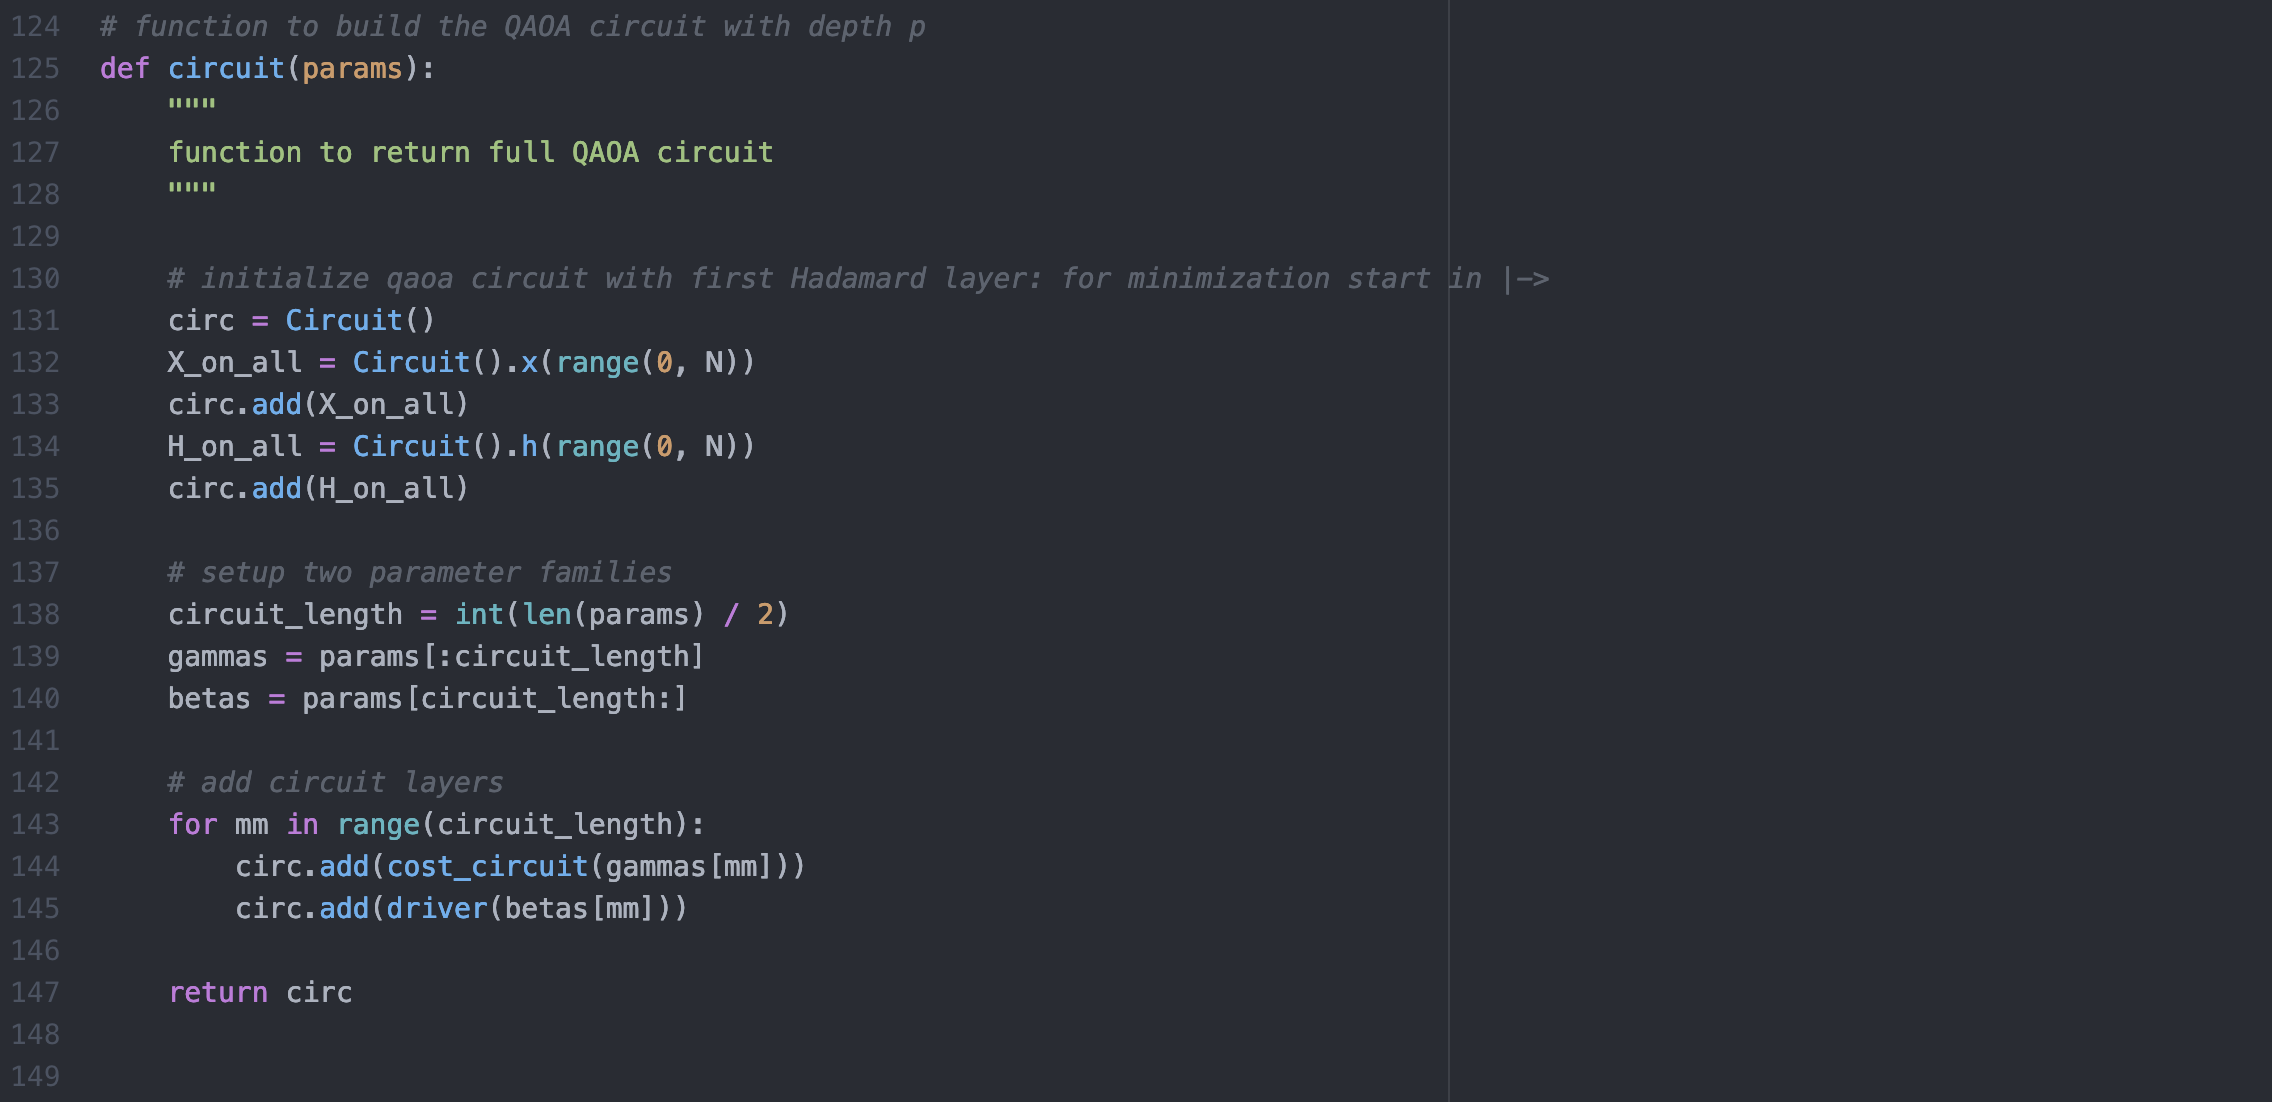

In [17]:
Image(filename='figures/script3.png', width=700, height=700)

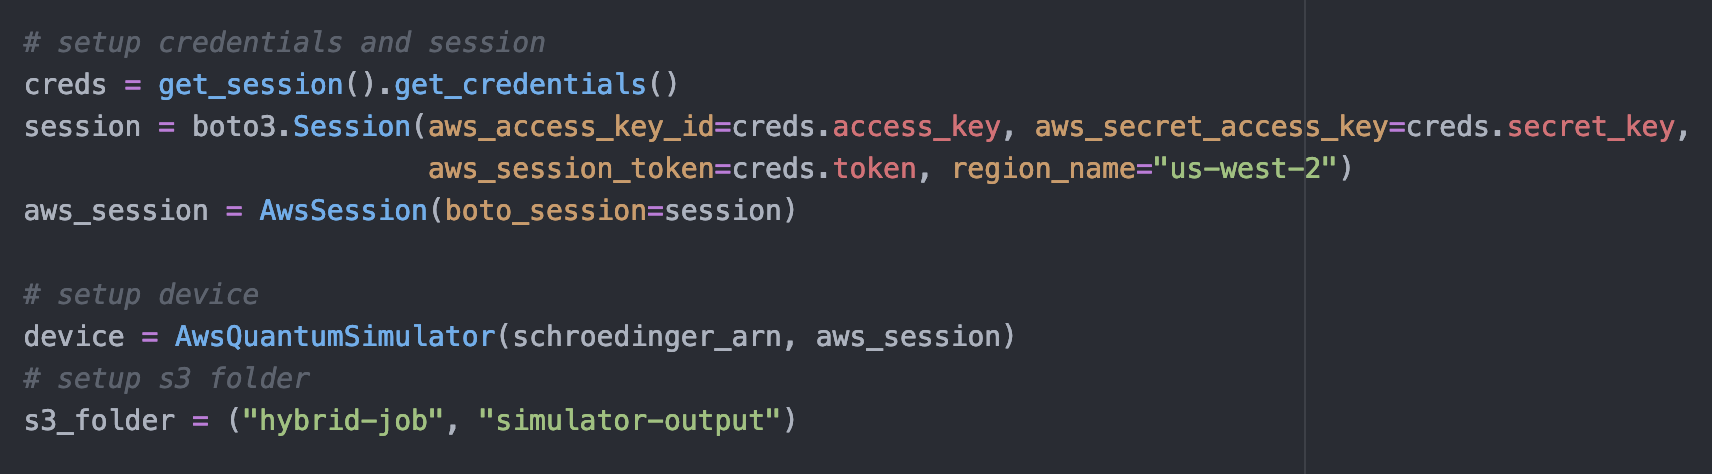

In [18]:
Image(filename='figures/script6.png', width=700, height=700)

__NOTE__: Changing to QPU (```device=...```) means changing one line of code here. 

In [19]:
# upload training script to s3
upload_file('qaoa_braket.py', bucket, 'qaoa_braket.py')

True

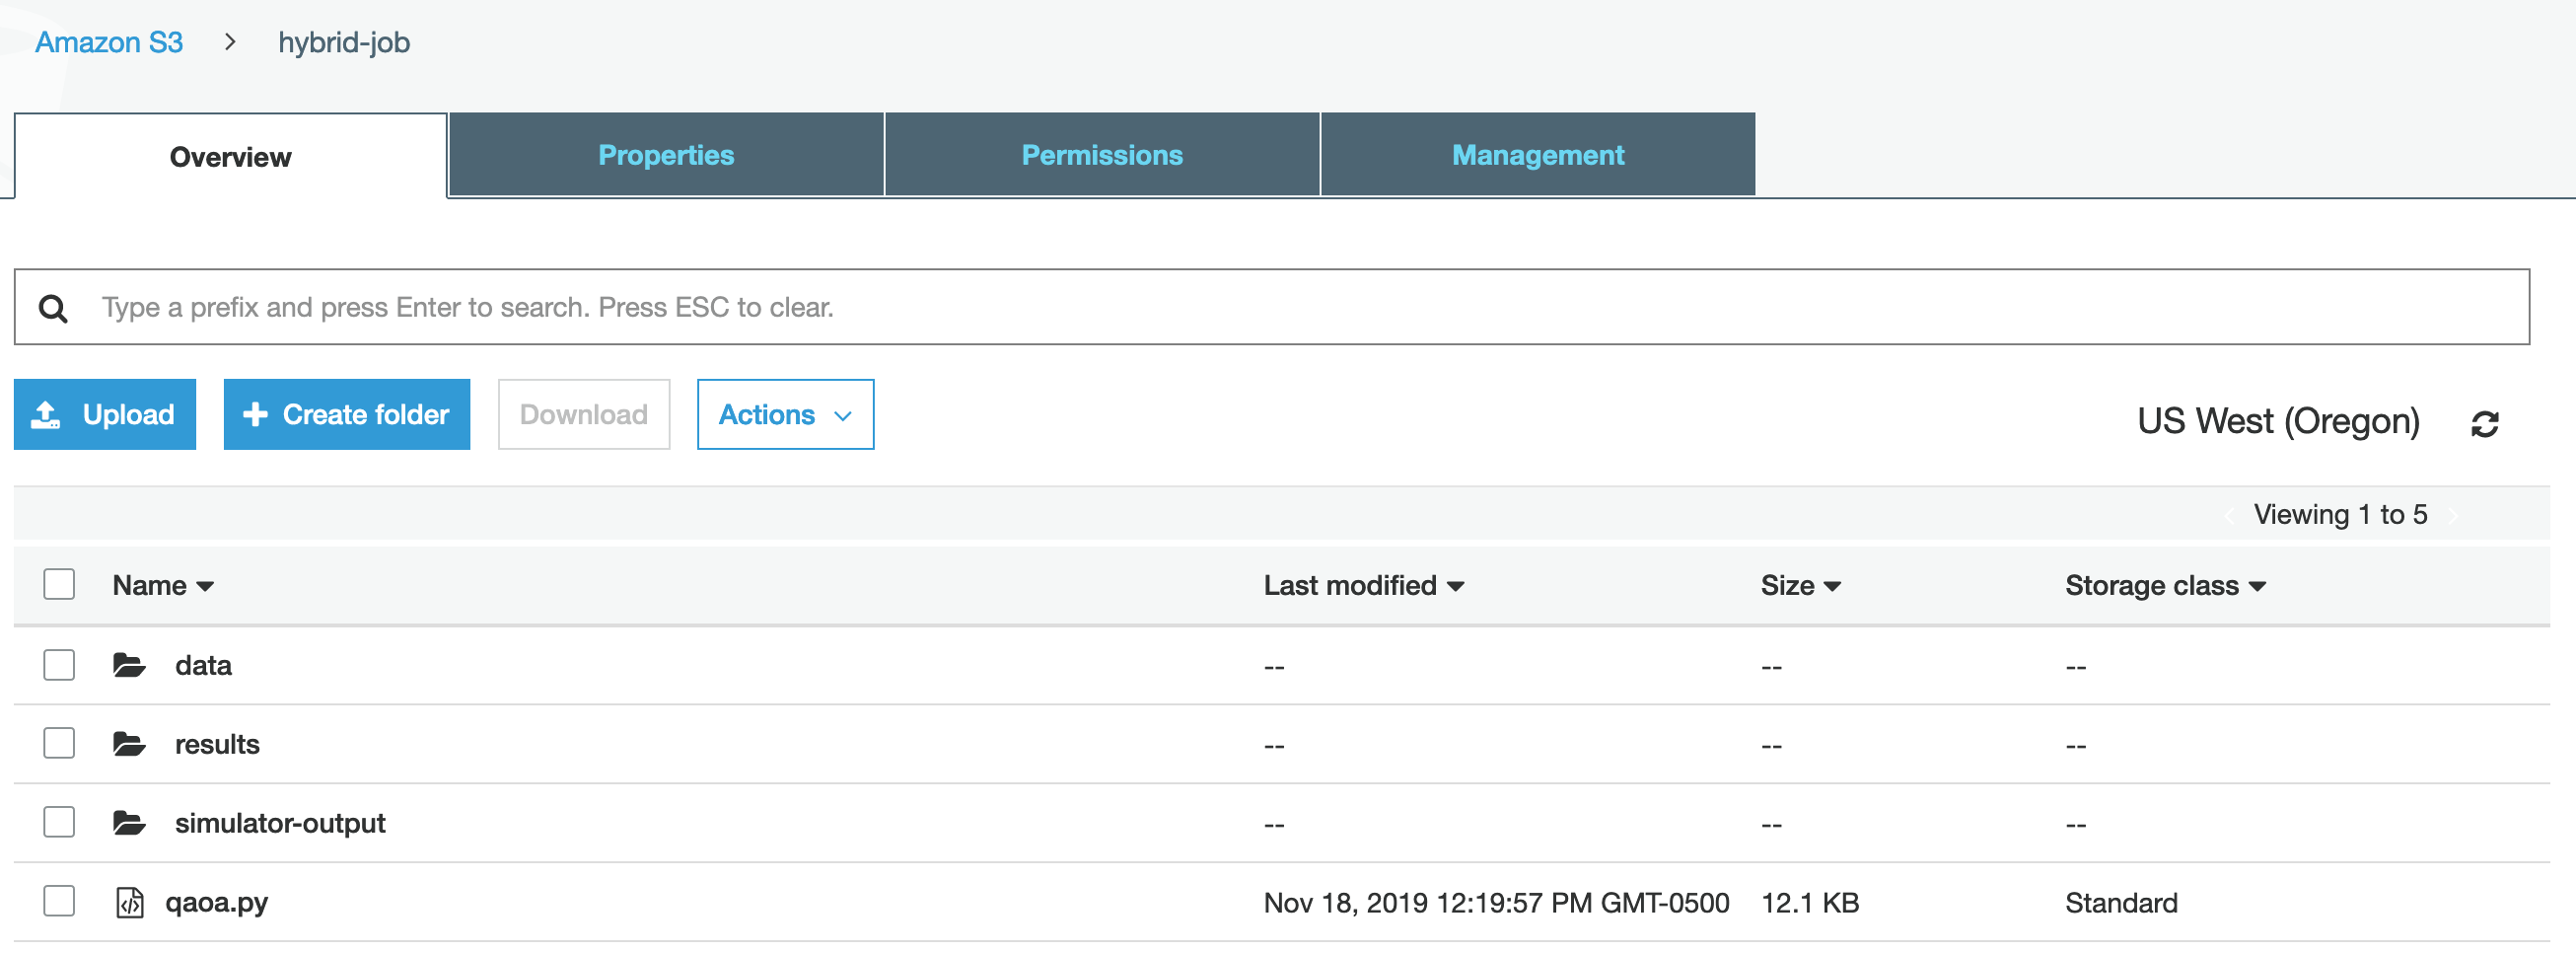

In [20]:
# screenshot from S3 location
Image(filename='figures/script_s3.png', width=800, height=800)

__Step 3__: Submit managed job specifying ```hardware``` in API call and pointing to the __S3 location__ where script with instructions is located. Customer can also define ```stoppingCondition``` and custom metrics to be tracked by __CloudWatch__. Hybrid algorithms executed by Amazon Braket service as managed jobs can automatically export metrics to Amazon CloudWatch. 

To export metrics to Amazon CloudWatch: 
1.	Decide the metrics that you want to emit. This can be done while writing the hybrid algorithm.
2.	Decide the format that the generated metrics will take.
Metrics will be automatically pushed to Amazon CloudWatch. 

In [21]:
# run training job tagged with custom job name
project_name = 'qaoa'
job_name = project_name+'-'+datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print('jobName with time stamp:', job_name)

jobName with time stamp: qaoa-20200716123151


In [22]:
# call API
my_role = config.role # enter your execution role here; see config file
output_path = "s3://"+bucket+"/results" # enter your output path here
hardware = "ml.m4.xlarge" # this is the EC2 instance type that runs the classical part of the computation
my_python_script = "qaoa_braket.py"
circuit_depth = 3 # hyperparameter: circuit depth of QAOA ansatz
device_type = "simulator" # choose 'simulator' or 'qpu'
device_arn = "qs1" # backend for circuit execution: "qs1" 
# device_type = "qpu"
# device_arn = "ionq" # if device_type=='qpu', choose 'ionq' or 'rigetti' (note: rigetti does not support zz gate)

quantum_job = braket_client.create_quantum_job(
    jobName=job_name,
    resourceConfig={                          # the classical part of the computation runs 
        "instanceCount": 1,                   # on a single m4.xlarge instance with 50GB volume size
        "instanceType": hardware,
        "volumeSizeInGb": 50
    },
    outputDataConfig={
        "s3OutputPath": output_path           # This is where results will be stored.
    },
    stoppingCondition={
        "maxRuntimeInSeconds": 86400          # the job aborts after 1 day
    },
    sagemakerRoleArn=my_role,
    inputScriptConfig={
        "scriptS3Bucket": bucket,
        "scriptS3ObjectKey": my_python_script # This is where your script is stored 
    },
    metricDefinitions = [{                    # We are looking for the custom metric cost_avg which we are catching
        'name': "cost_avg",                   # using regex expressions from stdout. This metric is reported out to 
        'regex': "cost_avg=(.*?);"            # CloudWatch
    }],
    hyperParameters={                         # You can pass any hyperparameters into your algorithm here
        'p': str(circuit_depth),
        'bucket': config.bucket,              # The bucket and key where your tasks are stored are required.
        'bucket_key': config.bucket_key,
        'device_type': device_type,           # set the backend for circuit execution
        'device_arn': device_arn,
        'input_data': s3_filename,            # input data location
        'region': config.region,
        },
)

# print results location
print('Results will be stored here:', output_path)

Results will be stored here: s3://hybrid-job-mjas/results


In [23]:
# print quantum Job metadata with date, status code etc.
date = quantum_job['ResponseMetadata']['HTTPHeaders']['date']
print(date)

Thu, 16 Jul 2020 16:31:54 GMT


In [24]:
# programmatically check the status of job
# corresponding CLI call: aws braket get-quantum-job --quantum-job-arn my_job_arn
quantum_job_arn = quantum_job['quantumJobArn']
job_info = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)
job_status = job_info['jobStatus']

In [25]:
# regularly check job status
# wait for job to complete
terminal_states = ['Completed', 'Failed', 'Cancelled']
while job_status not in terminal_states:
    job_status = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)['jobStatus']
    print('Status:', job_status)
    time.sleep(30)

Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: Completed


__NOTE__: If needed, you can also programmatically cancel a job in flight using the stop-quantum-job API; see ```aws braket stop-quantum-job help``` for details. 

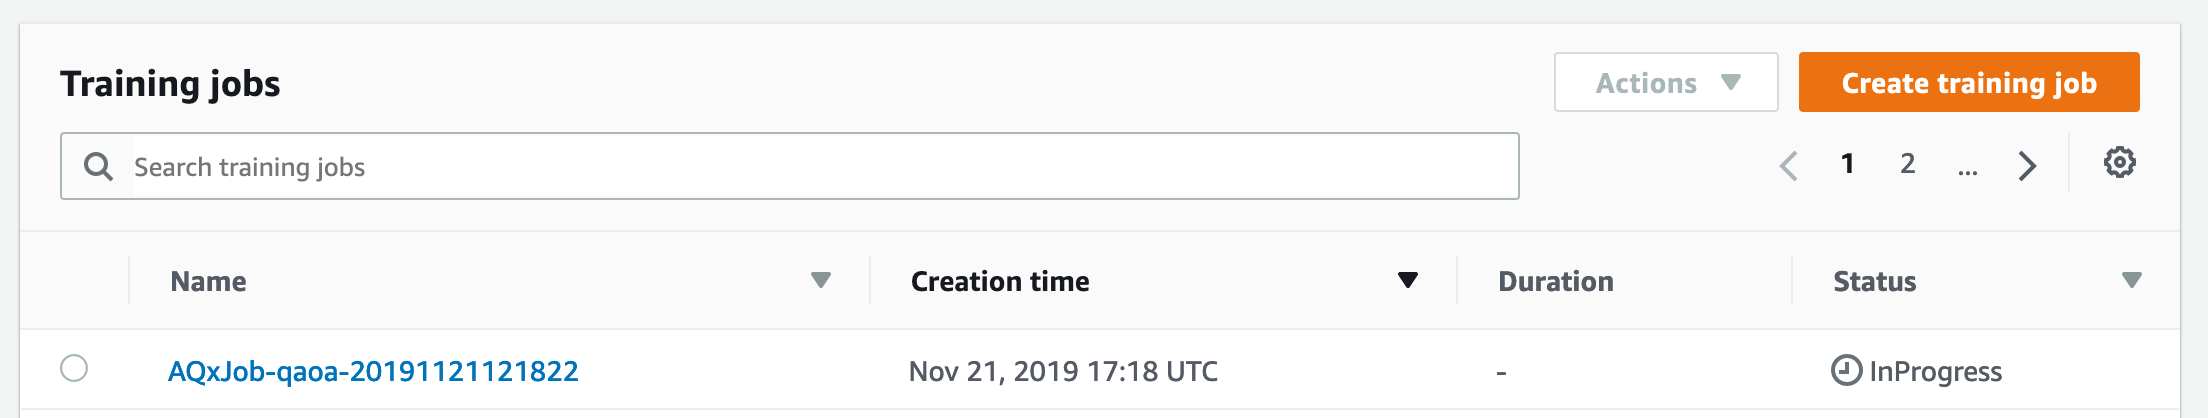

In [26]:
# screenshot from console
Image(filename='figures/job_in_progress2.png', width=1000, height=1000)

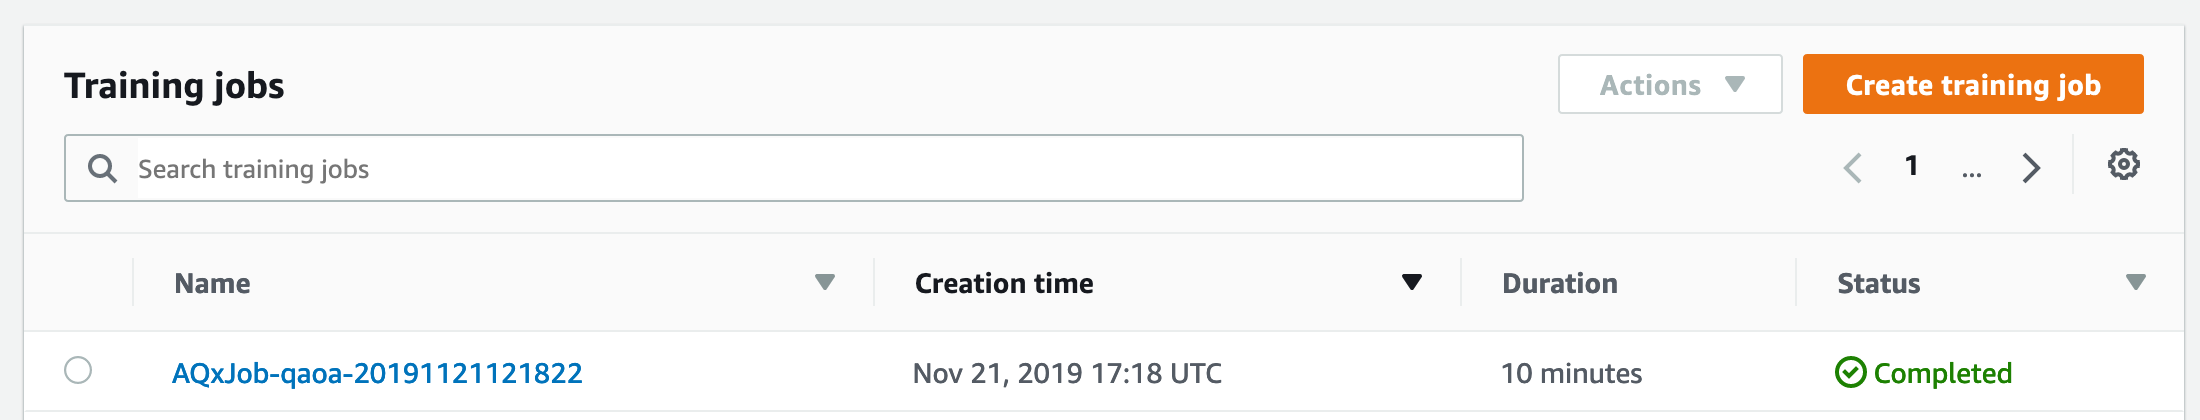

In [27]:
# screenshot from console
Image(filename='figures/job_completed.png', width=1000, height=1000)

### Track Custom Metrics of Managed Job in CloudWatch

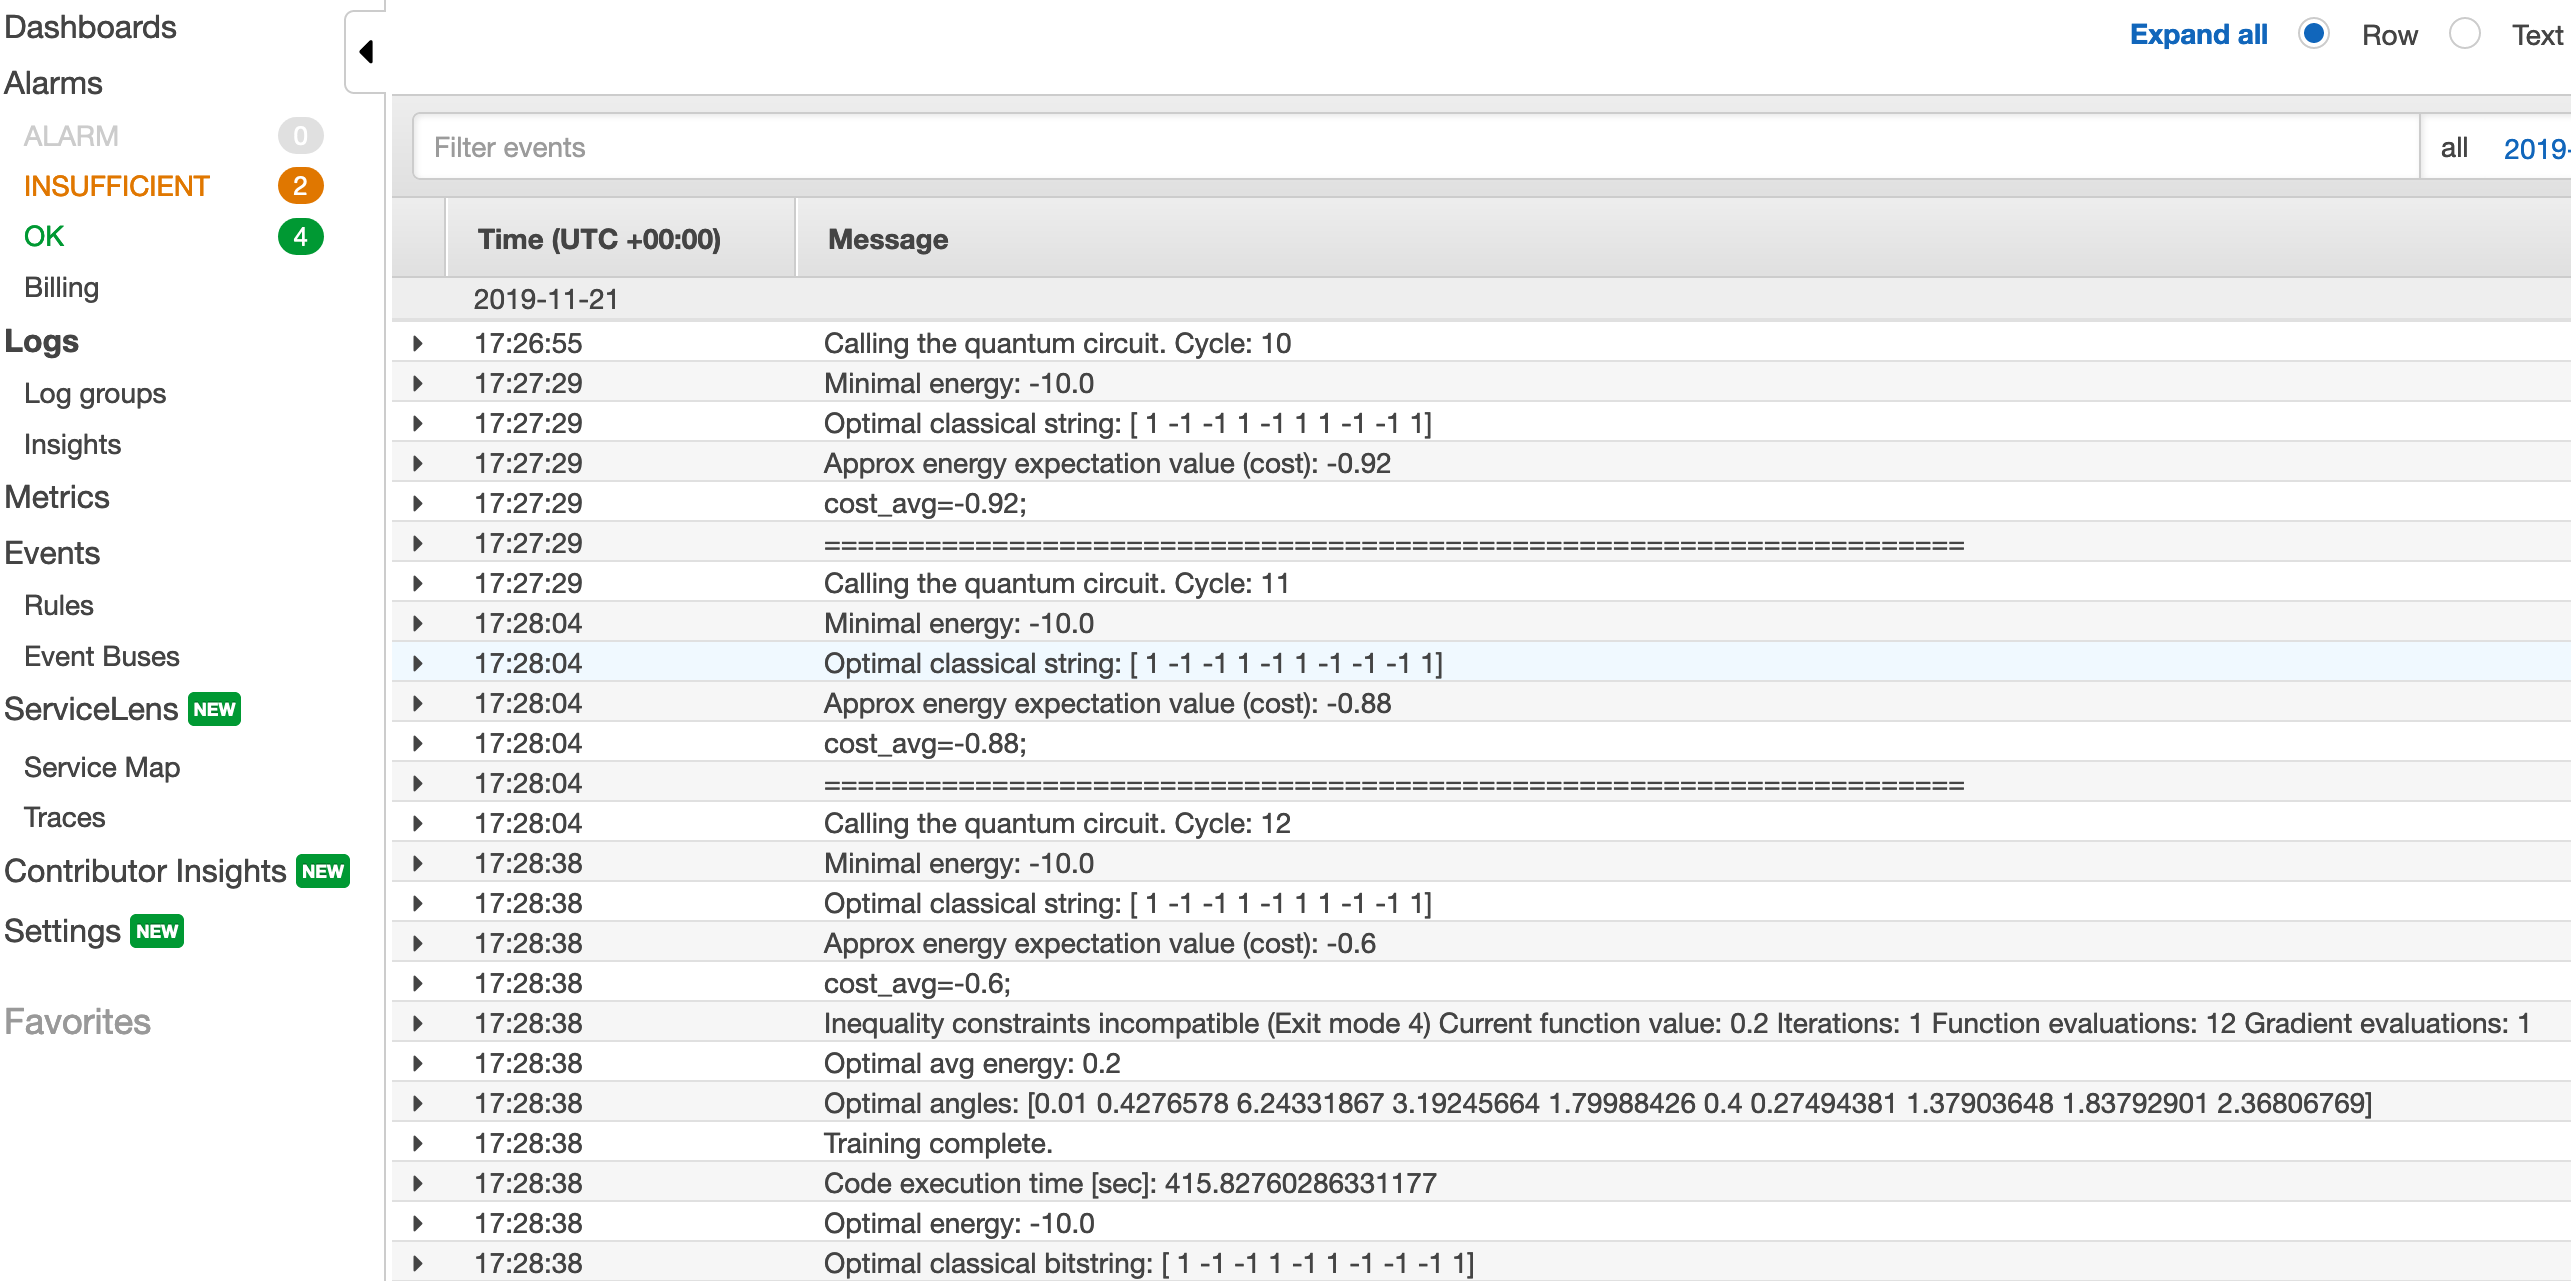

In [28]:
# visualize custom metrics in CloudWatch console
Image(filename='figures/cw_logs.png', width=700, height=700)

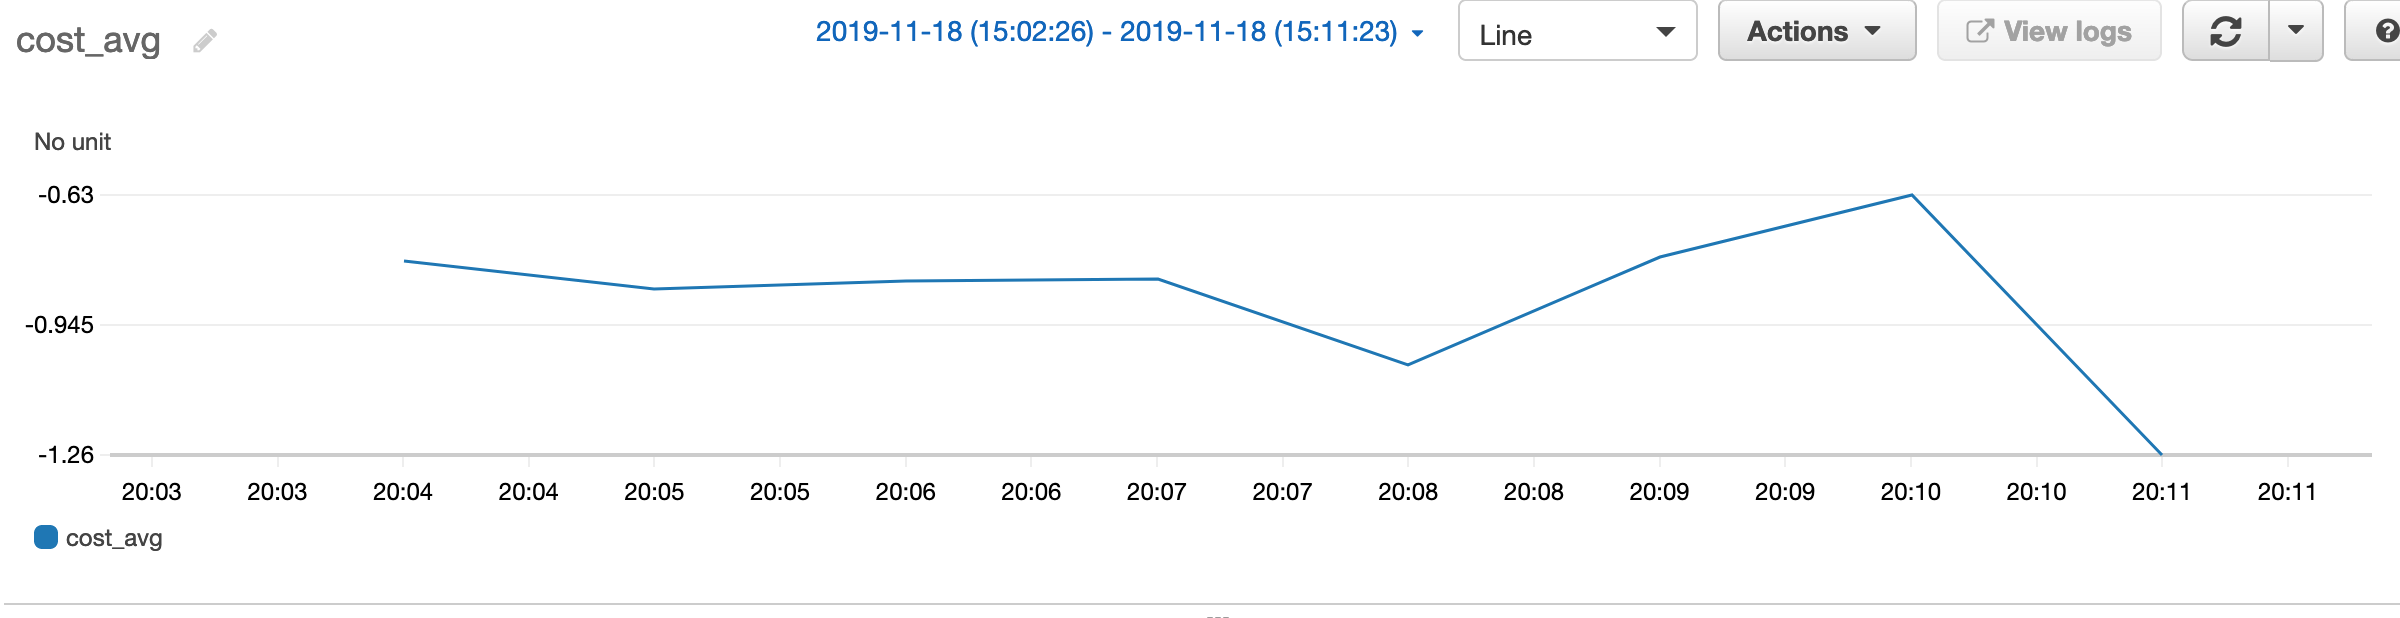

In [29]:
# visualize custom metrics in CloudWatch console
Image(filename='figures/cloudwatch_metric.png', width=1000, height=1000)

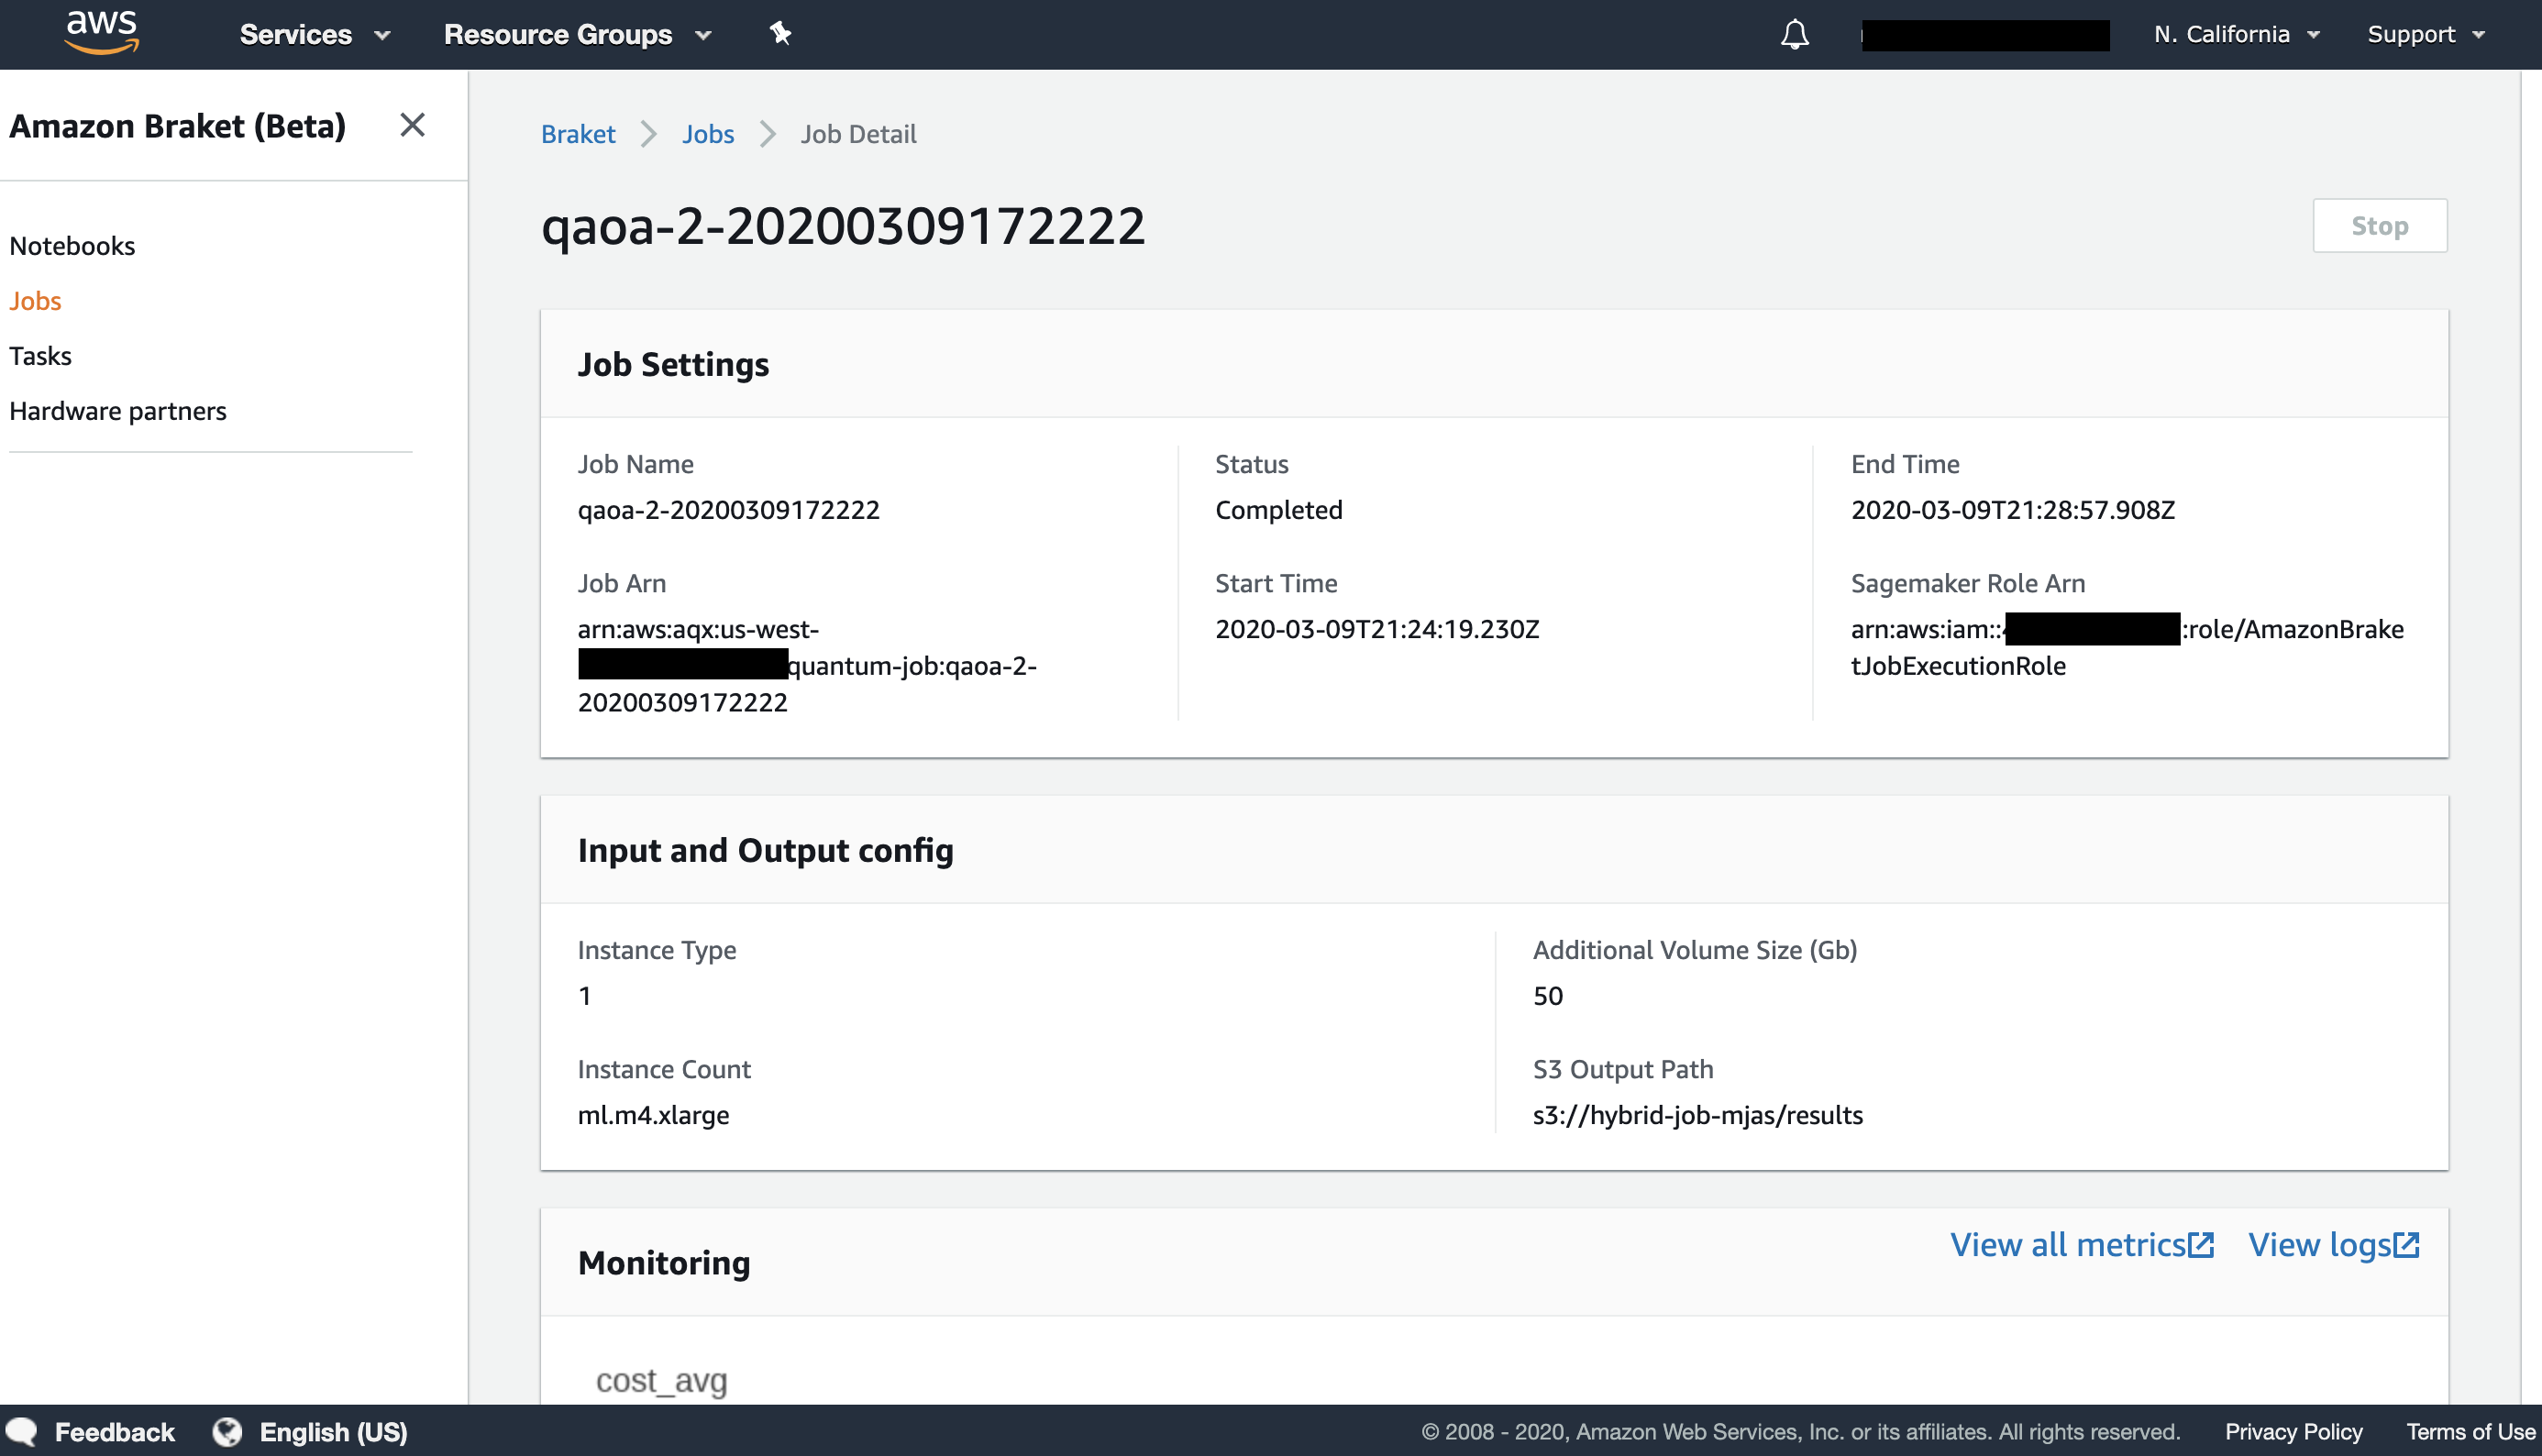

In [30]:
# CloudWatch custom metrics integrated into Braket console 
Image(filename='figures/Braket_console.png', width=800, height=800)

### Visualize Results of Managed Job

Once the managed job is done, results are packed up and stored an S3.

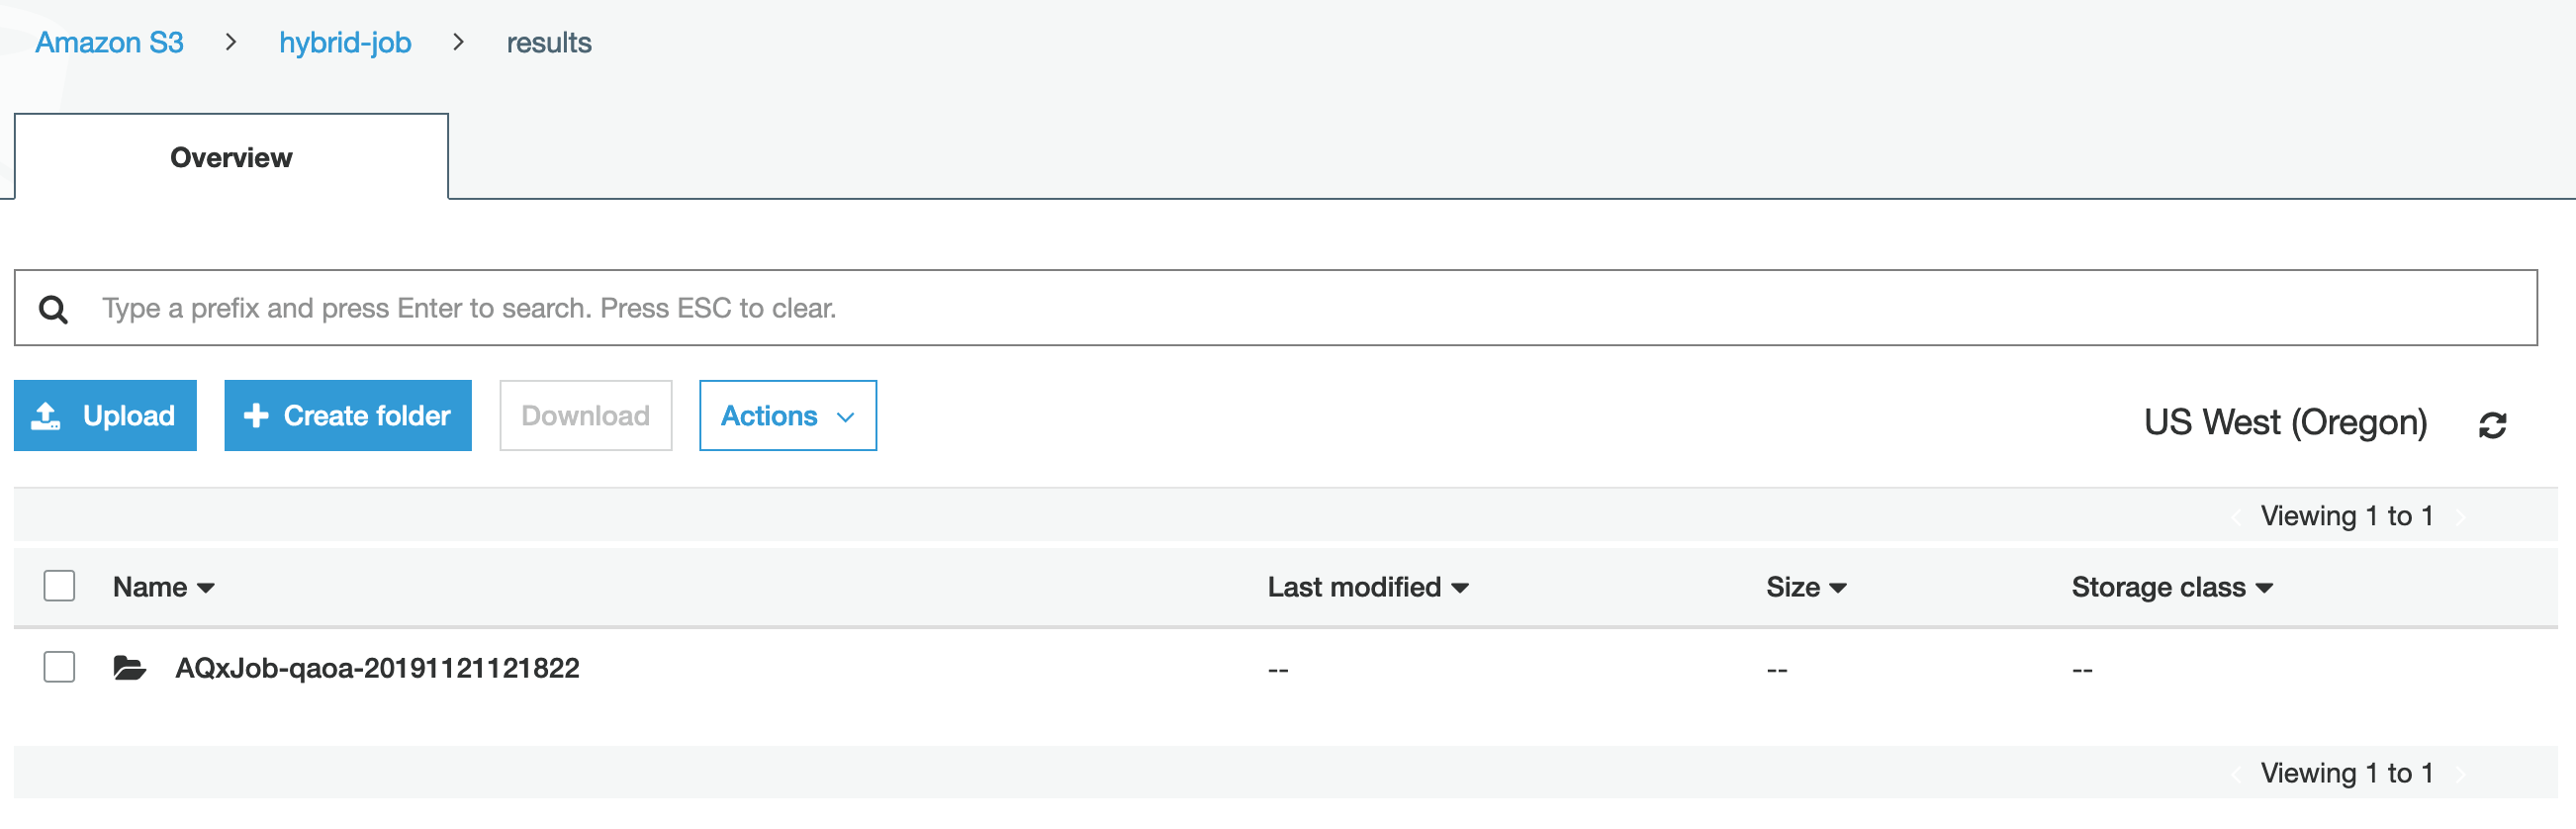

In [31]:
# screenshot from S3 location
Image(filename='figures/results_s3.png', width=800, height=800)

__Step 4__: Retrieve results stored in S3 and analyze and visualize. Enter your bucket below. 

In [32]:
# get the results from S3
# syntax: s3.download_file('BUCKET_NAME', 'OBJECT_NAME', 'FILE_NAME')
object_key = 'results/{}/output/model.tar.gz'.format('AQxJob-'+job_name)
tempfile = '/tmp/model.tar.gz' 
s3_client = session.client("s3")
s3_client.download_file(bucket, object_key, tempfile) # enter your bucket here

In [33]:
# unzip the results
tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = '/tmp')

# load the results into the notebook
out = pickle.load(open('/tmp/out.pckl', "rb"))

p = out['p']
N = out['N']              
ENERGY_OPTIMAL = out['ENERGY_OPTIMAL']               
BITSTRING = out['BITSTRING']
result_energy = out['result_energy']
result_angle = out['result_angle']

# clean-up temporary files
os.remove(tempfile) 

In [34]:
print('Optimal energy from managed job:', ENERGY_OPTIMAL)
print('Optimal bit-string from managed job:', BITSTRING)

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [ 1 -1 -1  1 -1  1 -1 -1 -1  1]


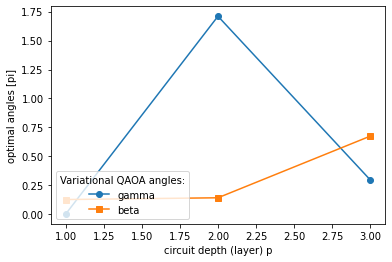

In [35]:
gamma = result_angle[:p]
beta = result_angle[p:]
pa = np.arange(1, p + 1)

fig = plt.figure(2)
plt.plot(pa, gamma / np.pi, '-o', label='gamma')
plt.plot(pa, beta / np.pi, '-s', label='beta')
plt.xlabel('circuit depth (layer) p')
plt.ylabel('optimal angles [pi]')
plt.legend(title='Variational QAOA angles:', loc='lower left')
plt.show()

Minimal energy found from QAOA job: -10.0


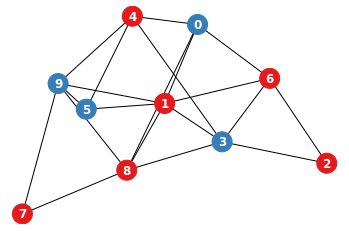

In [36]:
# visualize solution of managed job
colorlist = BITSTRING
colorlist[colorlist == -1] = 0

# plot_colored_graph(J, N, colorlist, pos)
plot_colored_graph_simple(G, colorlist, pos)
print('Minimal energy found from QAOA job:', ENERGY_OPTIMAL)

Classical solution: {'s0': -1, 's1': 1, 's2': 1, 's3': -1, 's4': 1, 's5': -1, 's6': 1, 's7': 1, 's8': 1, 's9': -1}
Minimal energy found classically: -10.0


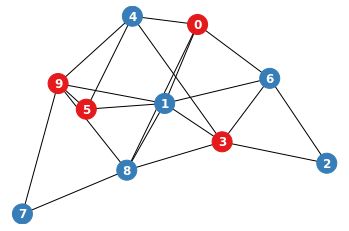

In [37]:
# validate quantum results with classical algorithm
solution, decoded_solution, energy_min, colors_classical = solve_classical_ising(J, N, pos)
# plot classical solution
plot_colored_graph_simple(G, colors_classical, pos)

__NOTE__: In this small toy problem there are many degenerate classical solutions with the same optimal quality. 

### Hyperparameter Optimization (HPO)

Run multiple jobs in parallel for hyperparameter optimization to speed up the research cycle. 

In [38]:
# specify all parameters for helper script
params = {'role': my_role,
          'output_path': output_path,
          'hardware': hardware,
          'bucket': bucket,
          'my_python_script': my_python_script,
          'p': str(circuit_depth),
          'bucket': config.bucket,              # The bucket and key where your tasks are stored are required.
          'bucket_key': config.bucket_key,
          'device_type': device_type,           # set the backend for circuit execution
          'device_arn': device_arn,
          'input_data': s3_filename,
          'region': config.region}

In [39]:
# kickoff HPO with grid search
jobs = []
quantum_jobs = []
circuit_depths = [2, 3, 4]

for pp in circuit_depths:
    # update circuit depth
    print('Starting training with circuit depth', pp)
    params['p'] = str(pp)
    jobname, quantum_job = kickoff_train(**params)
    jobs.append(jobname)
    quantum_jobs.append(quantum_job)
    print('=================================='*2)

Starting training with circuit depth 2
jobName with time stamp: qaoa-2-20200716123803
Starting training with circuit depth 3
jobName with time stamp: qaoa-3-20200716123804
Starting training with circuit depth 4
jobName with time stamp: qaoa-4-20200716123805


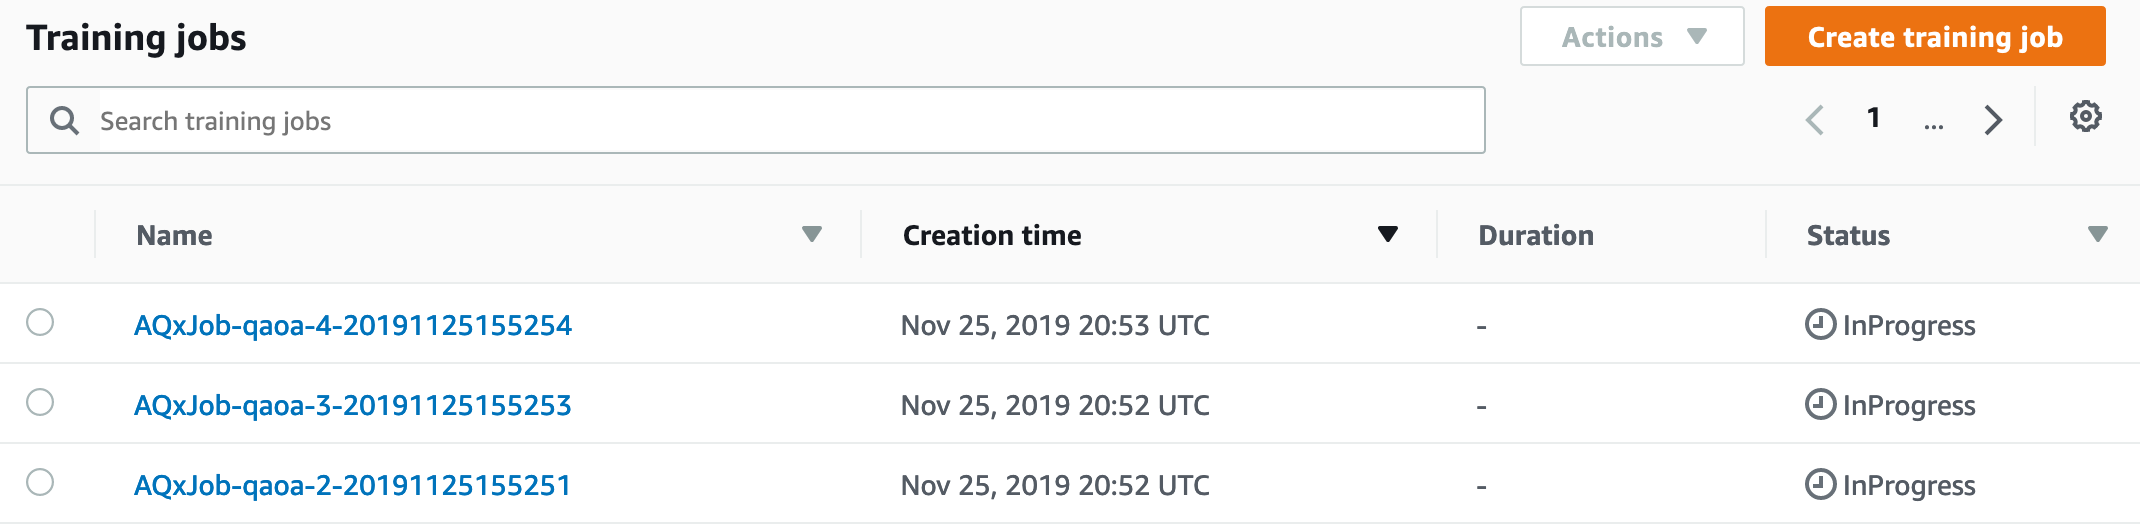

In [40]:
# screenshot from console
Image(filename='figures/jobs_hpo2.png', width=1000, height=1000)

In [41]:
# regularly check job status: wait for HPO jobs to complete
for idx, quantum_job in enumerate(quantum_jobs):
    # check status for every HPO job to be terminal
    print('Waiting for job {} to complete.'.format(jobs[idx]))
    quantum_job_arn = quantum_job['quantumJobArn']
    job_info = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)
    job_status = job_info['jobStatus']
    while job_status not in terminal_states:
        job_status = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)['jobStatus']
        print('HPO training still in progress.')
        time.sleep(60)

Waiting for job qaoa-2-20200716123803 to complete.
HPO training still in progress.
HPO training still in progress.
HPO training still in progress.
HPO training still in progress.
HPO training still in progress.
HPO training still in progress.
Waiting for job qaoa-3-20200716123804 to complete.
Waiting for job qaoa-4-20200716123805 to complete.


Once the jobs have completed, we can postprocess the results, visualize and analyze them. 

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [ 1 -1 -1  1 -1  1 -1 -1 -1  1]


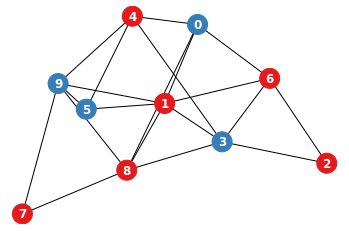

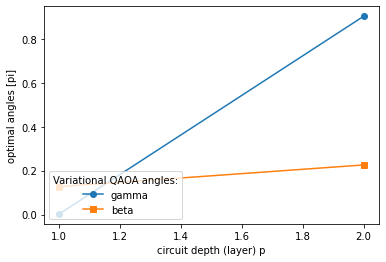

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [-1  1  1 -1  1 -1  1 -1  1 -1]


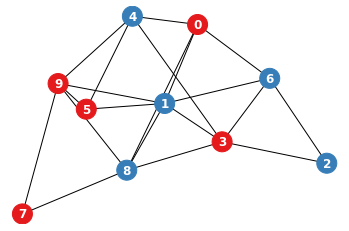

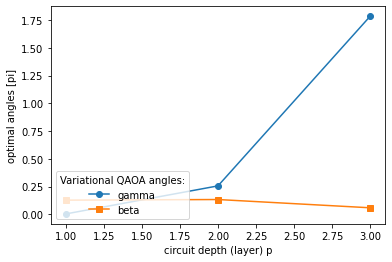

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [-1  1  1 -1  1 -1 -1 -1  1 -1]


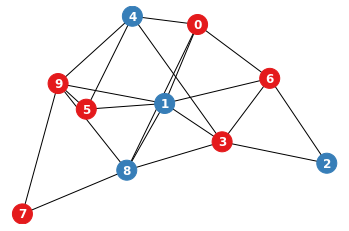

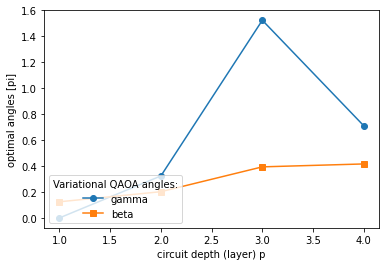

In [42]:
# postprocess HPO results
for job in jobs:
    # obtain results 
    p, N, ENERGY_OPTIMAL, BITSTRING, result_energy, result_angle, gamma, beta, pa = postprocess(job, bucket, config.region)
    
    # plot graph: visualize solution of managed job
    colorlist = BITSTRING
    colorlist[colorlist == -1] = 0
    # plot_colored_graph(J, N, colorlist)
    plot_colored_graph_simple(G, colorlist, pos)
    
    # print optimal parameters
    fig = plt.figure(2)
    plt.plot(pa, gamma / np.pi, '-o', label='gamma')
    plt.plot(pa, beta / np.pi, '-s', label='beta')
    plt.xlabel('circuit depth (layer) p')
    plt.ylabel('optimal angles [pi]')
    plt.legend(title='Variational QAOA angles:', loc='lower left')
    plt.show()

### Managed Job using the CLI

Similarly, we can interact with the Braket APIs using the CLI and submit our simulation job directly from CLI. As with any other AWS service one can interact with them in three ways: (i) Console, (ii) SDK (boto3), or (iii) CLI. 

In [43]:
project_name = 'qaoa-cli'
training_job_name = project_name+'-'+datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print('Running Job:', training_job_name)

Running Job: qaoa-cli-20200716124413


In [44]:
# specify job as python dictionary 
# then write this dic to json file
sm_job = {
    "jobName": training_job_name,
    "sagemakerRoleArn": my_role,
    "inputScriptConfig": {
        "scriptS3Bucket": bucket,
        "scriptS3ObjectKey": my_python_script # This is where your script is stored
    },
    "outputDataConfig": {
        "s3OutputPath": output_path
    },
    "resourceConfig": {                       # the classical part of the computation runs 
        "instanceType": hardware,             # on a single m4.xlarge instance with 50GB volume size
        "instanceCount": 1,
        "volumeSizeInGb": 30,
    },
    "stoppingCondition": {
        "maxRuntimeInSeconds": 86400,         # the job aborts after 1 day
    },
     "metricDefinitions": [{                  # We are looking for the custom metric cost_avg which we are catching
         'name': "cost_avg",                  # using regex expressions from stdout. This metric is reported out to
         'regex': "cost_avg=(.*?);"           # CloudWatch
    }],
    "hyperParameters": {                      # You can pass any hyperparameters into your algorithm here
        'p': str(circuit_depth),
        'bucket': config.bucket,              # The bucket and key where your tasks are stored are required.
        'bucket_key': config.bucket_key,
        'device_type': device_type,           # set the backend for circuit execution
        'device_arn': device_arn,
        'input_data': s3_filename,            # input data location
        'region': config.region,
        },
}

In [45]:
# save to JSON 
with open('qaoa_job.json', 'w') as outfile:
    json.dump(sm_job, outfile, indent=4)

In [46]:
! cat qaoa_job.json

{
    "jobName": "qaoa-cli-20200716124413",
    "sagemakerRoleArn": "arn:aws:iam::465542368797:role/AmazonBraketJobExecutionRole",
    "inputScriptConfig": {
        "scriptS3Bucket": "hybrid-job-mjas",
        "scriptS3ObjectKey": "qaoa_braket.py"
    },
    "outputDataConfig": {
        "s3OutputPath": "s3://hybrid-job-mjas/results"
    },
    "resourceConfig": {
        "instanceType": "ml.m4.xlarge",
        "instanceCount": 1,
        "volumeSizeInGb": 30
    },
    "stoppingCondition": {
        "maxRuntimeInSeconds": 86400
    },
    "metricDefinitions": [
        {
            "name": "cost_avg",
            "regex": "cost_avg=(.*?);"
        }
    ],
    "hyperParameters": {
        "p": "3",
        "bucket": "hybrid-job-mjas",
        "bucket_key": "hybrid-output",
        "device_type": "simulator",
        "device_arn": "qs1",
        "input_data": "data/data_ising.csv",
        "region": "us-west-1"
    }
}

__Note__: Next we hit the ```create-quantum-job``` Braket API with a CLI call. Depending on when you were whitelisted to Amazon Braket, you may need to replace the endpoint version appropriately, for example, with V2 $\rightarrow$ V3. The ednpoints are available [here](https://github.com/aws/braket-python-sdk/blob/master/src/braket/aws/aws_session.py#L24). Also, you can pull the endpoint programmatically, with (for example) ```aws_session.BRAKET_ENDPOINTS['us-west-1']```, provided that you have updated your version of the SDK to the latest one in stable/latest branch.

In [47]:
! aws braket create-quantum-job --cli-input-json file://qaoa_job.json --region us-west-1 --endpoint "https://fdoco1n1x7.execute-api.us-west-1.amazonaws.com/V3/"

{
    "quantumJobArn": "arn:aws:aqx:us-west-1:465542368797:quantum-job:qaoa-cli-20200716124413"
}


In [48]:
# ! aws braket create-quantum-job --cli-input-json file://qaoa_job.json --region us-west-2 --endpoint "https://xe15dbdvw6.execute-api.us-west-2.amazonaws.com/V3"

In [49]:
# ! aws braket create-quantum-job --cli-input-json file://qaoa_job.json --region us-east-1 --endpoint ""https://kqjovr0n70.execute-api.us-east-1.amazonaws.com/V3"

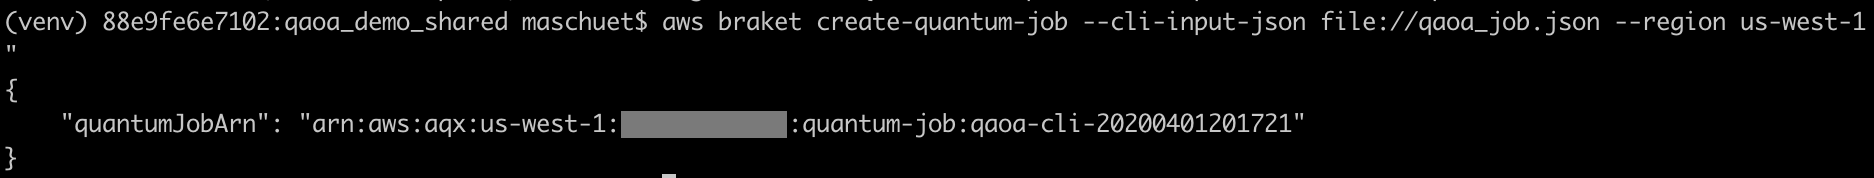

In [50]:
# screenshot of CLI
Image(filename='figures/cli_job.png', width=700, height=700)

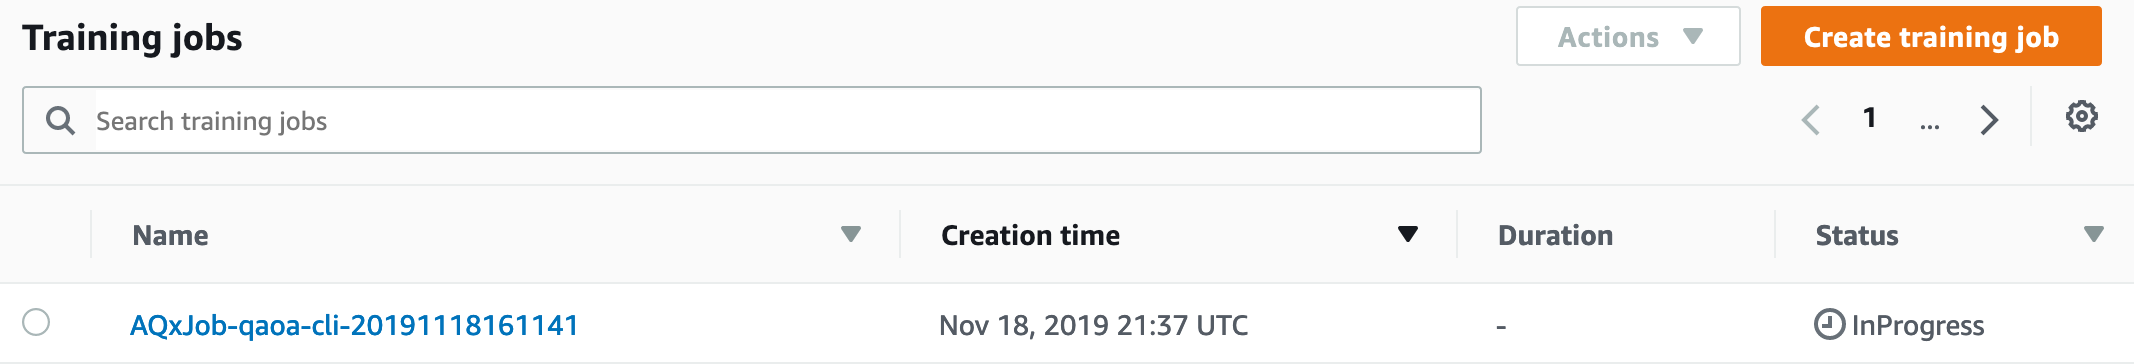

In [51]:
# screenshot from console
Image(filename='figures/job_in_progress_cli.png', width=700, height=700)